# REPORT MODEL MASKED FACE RECOGNITION

# Table of Content
- [BASIS THEORY](#Basis-theory)
- [DETECTION](#Detection)
- [RECOGNITION](#Recognition)
- [BUILDING MODEL](#Building-model)
- [EVALUATION](#Evaluation)

## BASIS THEORY

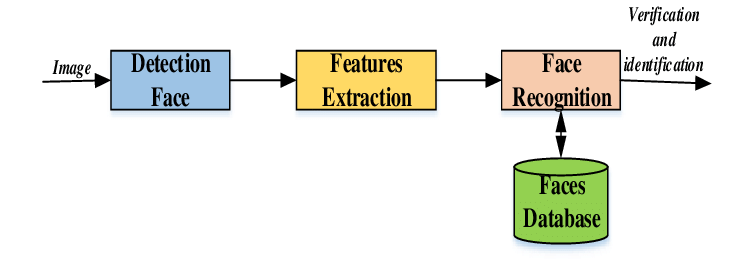

## DETECTION

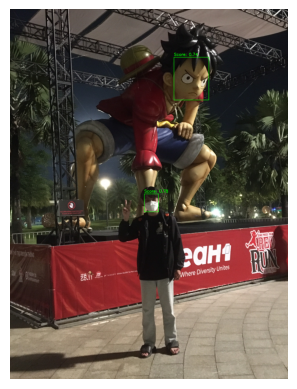

In [1]:
import cv2
import matplotlib.pyplot as plt

from FPTvision.operation import RetinaFace


retinaface = RetinaFace(model_file='./FPTvision/models/detection.onnx')

# Load image
image_path = 'Masked.jpg'
image = cv2.imread(image_path)

# Perform detection
detections, keypoints = retinaface.detect(image, input_size=(image.shape[0], image.shape[1]), max_num=0, metric='default')

# Visualize detections
for detection in detections:
    x1, y1, x2, y2, score = detection
    cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    cv2.putText(image, f'Score: {score:.2f}', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Convert image from BGR to RGB for matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the result using matplotlib
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


## RECOGNITION

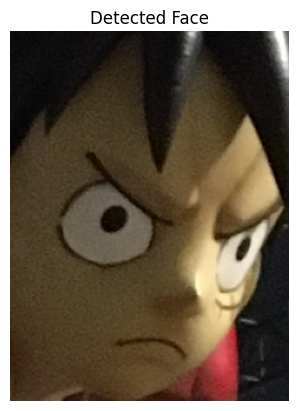

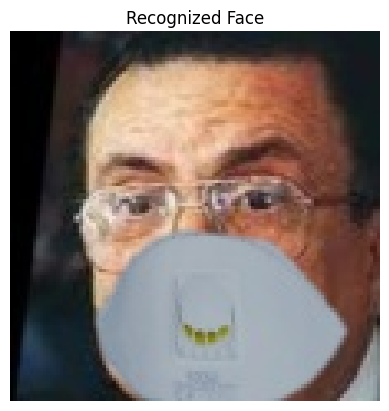

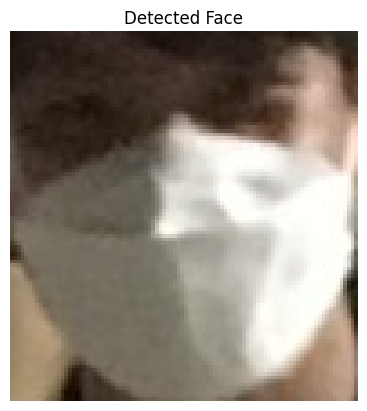

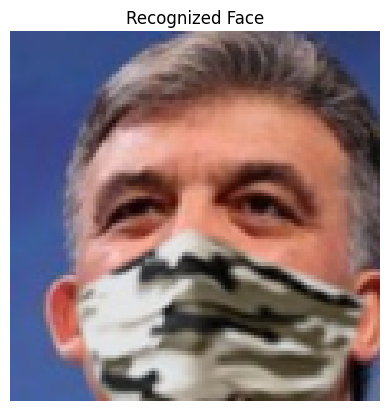

In [ ]:
import cv2
import glob
import matplotlib.pyplot as plt
from FPTvision.operation import ArcFace
from FPTvision.operation import RetinaFace

retinaface = RetinaFace(model_file='./FPTvision/models/detection.onnx')
arcface = ArcFace(model_file='./FPTvision/models/recognition.onnx')

# Đường dẫn đến thư mục chứa các khuôn mặt đã aligned
aligned_faces_dir = 'aligned'
aligned_faces = []
aligned_embeddings = []
aligned_face_files = glob.glob(aligned_faces_dir + '/*.jpg')
for face_file in aligned_face_files:
    face_image = cv2.imread(face_file)
    aligned_faces.append(face_image)

aligned_embeddings = arcface.get_feat(aligned_faces)

# Đường dẫn tới bức ảnh
image_path = 'Masked.jpg'

# Đọc ảnh gốc từ file
image = cv2.imread(image_path)

# Phát hiện khuôn mặt trong ảnh gốc
detections, keypoints = retinaface.detect(image, input_size=(640, 480))

# Duyệt qua các khuôn mặt đã phát hiện và thực hiện recognition
for detection, keypoint in zip(detections, keypoints):
    bbox = detection.astype(int)
    detected_face_img = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    detected_embedding = arcface.get_feat([detected_face_img])
    max_similarity = 0
    recognized_face_idx = -1

    # So sánh với các khuôn mặt đã aligned để tìm khuôn mặt giống nhất
    for idx, aligned_embedding in enumerate(aligned_embeddings):
        similarity = arcface.compute_sim(aligned_embedding, detected_embedding)
        if similarity > max_similarity:
            max_similarity = similarity
            recognized_face_idx = idx

    if recognized_face_idx != -1:
        recognized_face = aligned_faces[recognized_face_idx]

        # Hiển thị ảnh khuôn mặt phát hiện được
        plt.imshow(cv2.cvtColor(detected_face_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Detected Face')
        plt.show()

        # Hiển thị ảnh khuôn mặt được nhận dạng
        plt.imshow(cv2.cvtColor(recognized_face, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Recognized Face')
        plt.show()

    else:
        print("Không nhận dạng được khuôn mặt.")

## BUILDING MODEL

In [ ]:
import torch
from torch import nn
from torch.utils.checkpoint import checkpoint
from torchvision.transforms import functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

import math
from PIL import Image
import numpy as np

from tqdm import tqdm

using_ckpt = False

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=dilation,
                     groups=groups,
                     bias=False,
                     dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)


class IBasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1):
        super(IBasicBlock, self).__init__()
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        self.bn1 = nn.BatchNorm2d(inplanes, eps=1e-05,)
        self.conv1 = conv3x3(inplanes, planes)
        self.bn2 = nn.BatchNorm2d(planes, eps=1e-05,)
        self.prelu = nn.PReLU(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn3 = nn.BatchNorm2d(planes, eps=1e-05,)
        self.downsample = downsample
        self.stride = stride

    def forward_impl(self, x):
        identity = x
        out = self.bn1(x)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return out        

    def forward(self, x):
        if self.training and using_ckpt:
            return checkpoint(self.forward_impl, x)
        else:
            return self.forward_impl(x)


class IResNet(nn.Module):
    fc_scale = 7 * 7
    def __init__(self,
                 block, layers, dropout=0, num_features=512, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None, fp16=False):
        super(IResNet, self).__init__()
        self.extra_gflops = 0.0
        self.fp16 = fp16
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes, eps=1e-05)
        self.prelu = nn.PReLU(self.inplanes)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=2)
        self.layer2 = self._make_layer(block,
                                       128,
                                       layers[1],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block,
                                       256,
                                       layers[2],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block,
                                       512,
                                       layers[3],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.bn2 = nn.BatchNorm2d(512 * block.expansion, eps=1e-05,)
        self.dropout = nn.Dropout(p=dropout, inplace=True)
        self.fc = nn.Linear(512 * block.expansion * self.fc_scale, num_features)
        self.features = nn.BatchNorm1d(num_features, eps=1e-05)
        nn.init.constant_(self.features.weight, 1.0)
        self.features.weight.requires_grad = False

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0, 0.1)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, IBasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion, eps=1e-05, ),
            )
        layers = []
        layers.append(
            block(self.inplanes, planes, stride, downsample, self.groups,
                  self.base_width, previous_dilation))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(self.inplanes,
                      planes,
                      groups=self.groups,
                      base_width=self.base_width,
                      dilation=self.dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        with torch.cuda.amp.autocast(self.fp16):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.prelu(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.bn2(x)
            x = torch.flatten(x, 1)
            x = self.dropout(x)
        x = self.fc(x.float() if self.fp16 else x)
        x = self.features(x)
        return x


def _iresnet(arch, block, layers, pretrained, progress, **kwargs):
    model = IResNet(block, layers, **kwargs)
    if pretrained:
        raise ValueError()
    return model

def iresnet100(pretrained=False, progress=True, **kwargs):
    return _iresnet('iresnet100', IBasicBlock, [3, 13, 30, 3], pretrained,
                    progress, **kwargs)
    
# Định nghĩa lại class CombinedMarginLoss
class CombinedMarginLoss(torch.nn.Module):
    def __init__(self, s, m1, m2, m3, interclass_filtering_threshold=0):
        super().__init__()
        self.s = s
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        self.interclass_filtering_threshold = interclass_filtering_threshold
        
        self.cos_m = math.cos(self.m2)
        self.sin_m = math.sin(self.m2)
        self.theta = math.cos(math.pi - self.m2)
        self.sinmm = math.sin(math.pi - self.m2) * self.m2
        self.easy_margin = False

    def forward(self, logits, labels):
        index_positive = torch.where(labels != -1)[0]

        if self.interclass_filtering_threshold > 0:
            with torch.no_grad():
                dirty = logits > self.interclass_filtering_threshold
                dirty = dirty.float()
                mask = torch.ones([index_positive.size(0), logits.size(1)], device=logits.device)
                mask.scatter_(1, labels[index_positive], 0)
                dirty[index_positive] *= mask
                tensor_mul = 1 - dirty    
            logits = tensor_mul * logits

        target_logit = logits[index_positive, labels[index_positive].view(-1)]

        if self.m1 == 1.0 and self.m3 == 0.0:
            with torch.no_grad():
                target_logit.clamp_(-1 + 1e-7, 1 - 1e-7)
                logits.clamp_(-1 + 1e-7, 1 - 1e-7)
                target_logit.arccos_()
                logits.arccos_()
                final_target_logit = target_logit + self.m2
                logits[index_positive, labels[index_positive].view(-1)] = final_target_logit
                logits.cos_()
            logits = logits * self.s

        elif self.m3 > 0:
            final_target_logit = target_logit - self.m3
            logits[index_positive, labels[index_positive].view(-1)] = final_target_logit
            logits = logits * self.s
        else:
            raise ValueError("Invalid m1 and m3 values")

        return torch.relu(torch.mean(logits[index_positive]))

# Đường dẫn đến thư mục chứa dữ liệu huấn luyện
data_dir = './Data'

# Các tham số huấn luyện
batch_size = 32
num_epochs = 5
learning_rate = 0.0001

# Chuẩn bị dữ liệu huấn luyện
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    transforms.Lambda(lambda x: x.mul(255).clamp(0, 255).div(255)),  # Chuyển về giá trị trong khoảng [0, 255]
    transforms.Lambda(lambda x: x.float()),
    transforms.Lambda(lambda x: x.sub_(0.5).div_(0.5))  # Chuẩn hóa về khoảng [-1, 1]
])
dataset = ImageFolder(data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Đường dẫn đến file chứa trọng số
backbone_weights_path = "backbone.pth"

# Khởi tạo mô hình
model = iresnet100()

# Load trọng số từ file
checkpoint = torch.load(backbone_weights_path)
model.load_state_dict(checkpoint)

# Khởi tạo hàm loss
loss_fn = CombinedMarginLoss(s=64, m1=1.0, m2=0.5, m3=0.0, interclass_filtering_threshold=0)

# Đặt mô hình và hàm loss vào chế độ huấn luyện
model.train()
loss_fn.train()

# Sử dụng tối ưu hóa AdamW để cập nhật trọng số của mô hình``
optimizer = AdamW(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    total_loss = 0.0
    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.4f}")

100%|██████████| 2/2 [00:13<00:00,  6.70s/it]


Epoch 1/5, Loss: 0.1184


100%|██████████| 2/2 [00:12<00:00,  6.36s/it]


Epoch 2/5, Loss: 0.0312


100%|██████████| 2/2 [00:12<00:00,  6.32s/it]


Epoch 3/5, Loss: 0.2255


100%|██████████| 2/2 [00:12<00:00,  6.08s/it]


Epoch 4/5, Loss: 0.1439


100%|██████████| 2/2 [00:12<00:00,  6.13s/it]

Epoch 5/5, Loss: 0.0372


## EVALUATION

In [8]:
import cv2
import glob
import numpy as np
from FPTvision.operation import ArcFace

arcface = ArcFace(model_file='./FPTvision/models/recognition.onnx')

aligned_faces_dir = 'Validation'  # Thư mục chứa các ảnh đã được label
aligned_embeddings = []
aligned_face_files = glob.glob(aligned_faces_dir + '/*.jpg')

# Chuyển đổi các ảnh đã được label sang dạng vector và lưu tên của bức ảnh
for idx, face_file in enumerate(aligned_face_files):
    face_image = cv2.imread(face_file)
    embedding = arcface.get_feat([face_image])[0]
    name_parts = face_file.split("\\")[1].split('_')
    name = '_'.join(name_parts[:-2])
    aligned_embeddings.append((embedding, name))

# Tạo bộ khuôn mặt anchor
anchor_embeddings = []
anchor_face_files = []

for idx, (embedding, name) in enumerate(aligned_embeddings):
    if name not in anchor_face_files:
        anchor_embeddings.append(embedding)
        anchor_face_files.append(name)

# Phân loại những bức ảnh còn lại
total_images = len(aligned_face_files)
correct_count = 0

for idx, (embedding, name) in enumerate(aligned_embeddings):
    max_similarity = 0
    recognized_face_idx = -1

    # So sánh với các khuôn mặt anchor để tìm khuôn mặt giống nhất
    for idx, anchor_embedding in enumerate(anchor_embeddings):
        similarity = arcface.compute_sim(anchor_embedding, embedding)
        if similarity > max_similarity:
            max_similarity = similarity
            recognized_face_idx = idx

    # Kiểm tra tên của khuôn mặt được nhận dạng
    recognized_name = anchor_face_files[recognized_face_idx]
    true_name = name

    if recognized_name == true_name:
        correct_count += 1

accuracy = correct_count / total_images
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 89.07%


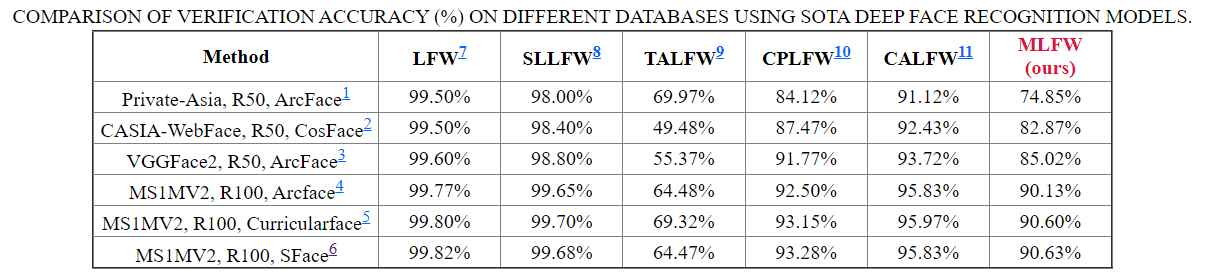